In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('tuesday_df.csv')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [5]:
print(df.shape)
df.head()

(21846, 38)


,id,name,description,neighborhood_overview,transit,neighborhood,state,zipcode,latitude,longitude,...,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,wifi,cable_tv,washer,kitchen,security,cost
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,It is located in the former East Berlin area o...,"Close to U-Bahn U8 and U2 (metro), Trams M12, ...",2,Berlin,10119,52.534537,13.402557,...,10.0,9.0,strict_14_with_grace_period,3.76,1,0,1,1,1,90.0
1,2695,Prenzlauer Berg close to Mauerpark,In the summertime we are spending most of our ...,NaN,Within walking distance you'll find the S-Bahn...,3,Berlin,10437,52.548513,13.404553,...,10.0,10.0,flexible,1.42,1,1,1,1,0,17.0
2,3176,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,"We are 5 min walk away from the tram M2, whic...",3,Berlin,10405,52.534996,13.417579,...,10.0,9.0,strict_14_with_grace_period,1.25,1,1,1,1,1,140.0
3,3309,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"My flat is in the middle of West-Berlin, direc...",The public transportation is excellent: Severa...,6,Berlin,10777,52.498855,13.349065,...,9.0,9.0,strict_14_with_grace_period,0.39,1,1,1,0,1,56.0
4,7071,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"Great neighborhood with plenty of Cafés, Baker...",Best access to other parts of the city via pub...,3,Berlin,10437,52.543157,13.415091,...,10.0,9.0,moderate,1.75,1,1,0,0,0,42.0


In [6]:
df_small = df[['neighborhood', 'room_type', 'accommodates', 'bedrooms',
                      'number_of_reviews', 'wifi', 'cable_tv', 'washer', 'kitchen',
                      'price']]

In [7]:
df_small.describe()

,neighborhood,room_type,accommodates,bedrooms,number_of_reviews,wifi,cable_tv,washer,kitchen,price
count,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000,21846.000000
mean,3.362538,1.536116,2.645748,1.163279,18.008377,0.954591,0.543303,0.836492,0.945986,67.499680
std,2.316131,0.524126,1.519138,0.647002,36.995728,0.208204,0.498133,0.369837,0.226051,223.627238
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,30.000000
50%,3.000000,2.000000,2.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,45.000000
75%,4.000000,2.000000,3.000000,1.000000,16.000000,1.000000,1.000000,1.000000,1.000000,70.000000
max,12.000000,3.000000,16.000000,12.000000,498.000000,1.000000,1.000000,1.000000,1.000000,9000.000000


In [8]:
df_hood = df_small.groupby(['neighborhood']).median()

In [9]:
df_hood.head(15)

,room_type,accommodates,bedrooms,number_of_reviews,wifi,cable_tv,washer,kitchen,price
neighborhood,,,,,,,,,
1,2.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,48.0
2,2.0,2.0,1.0,5.0,1.0,0.0,1.0,1.0,50.0
3,1.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,50.0
4,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,40.0
5,1.0,2.0,1.0,5.0,1.0,0.0,1.0,1.0,49.0
6,2.0,2.0,1.0,5.0,1.0,0.0,1.0,1.0,45.0
7,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,39.0
8,1.5,2.0,1.0,4.0,1.0,0.0,1.0,1.0,45.0
9,1.0,2.0,1.0,5.0,1.0,0.0,1.0,1.0,44.0


In [10]:
df_hood2 = df_small.groupby(['neighborhood']).mean()

In [11]:
df_hood2.head(15)

,room_type,accommodates,bedrooms,number_of_reviews,wifi,cable_tv,washer,kitchen,price
neighborhood,,,,,,,,,
1,1.558017,2.565715,1.133496,17.703905,0.959632,0.599887,0.846414,0.952309,60.894668
2,1.542793,2.781676,1.172067,22.244469,0.959777,0.495642,0.844916,0.938994,70.037765
3,1.444930,2.727273,1.216783,19.989510,0.950466,0.504079,0.841783,0.958333,68.071387
4,1.610467,2.392209,1.107939,13.260184,0.953613,0.755873,0.853405,0.961344,46.475171
5,1.480720,2.721080,1.165167,18.131105,0.956941,0.328406,0.807198,0.913882,115.544987
6,1.552268,2.658777,1.142669,17.433268,0.958580,0.474688,0.800789,0.923734,97.785667
7,1.587970,2.571429,1.097744,13.658647,0.941353,0.518797,0.804511,0.953383,56.440602
8,1.505172,2.832759,1.293103,13.913793,0.939655,0.481034,0.844828,0.951724,52.550000
9,1.490654,2.696262,1.287383,12.754673,0.950935,0.376168,0.824766,0.918224,55.577103


In [12]:
# removing bathrooms from model

train, test = train_test_split(df_small, test_size=0.20, shuffle=True)

target = 'price'
features = ['neighborhood', 'room_type', 'accommodates', 'bedrooms',
            'number_of_reviews', 'wifi', 'cable_tv', 'washer', 'kitchen']

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17476, 9), (4370, 9), (17476,), (4370,))

In [ ]:
pipeline = make_pipeline(RandomForestRegressor())

param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200, 500],
    'randomforestregressor__max_features': [4, 5, 6, 7, 8, 9],
    'randomforestregressor__min_samples_leaf': [1, 10, 50, 100]
}

search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1)

search.fit(X_train, y_train);

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/home/tcbic/anaconda3/envs/pipenv_base/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.7s
/home/tcbic/anaconda3/envs/pipenv_base/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  45 t

In [ ]:
print('best hyperparams', search.best_params_)
print('cross-val RMSLE', search.best_score_)

In [57]:
y_pred = search.predict(X_test)
print('rmse', rmse(y_test, y_pred))
print('rmsle', rmsle(y_test, y_pred))

rmse 189.32143549370934
rmsle 0.5090158286525418


In [61]:
(y_pred > 100).sum()

499

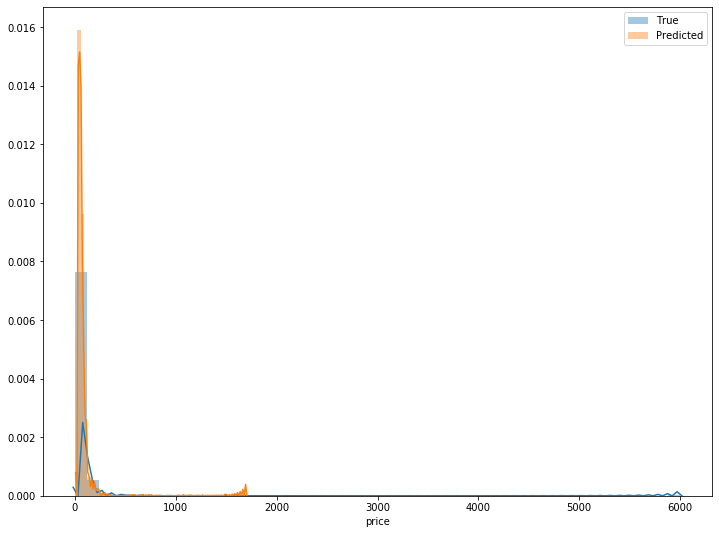

In [44]:
plt.figure(figsize=(12, 9))
sns.distplot(y_test, label='True')
sns.distplot(y_pred, label='Predicted')
plt.legend();

(array([4.253e+03, 8.200e+01, 3.000e+00, 1.100e+01, 6.000e+00, 0.000e+00,
        5.000e+00, 1.000e+00, 6.000e+00, 3.000e+00]),
 array([  22.52763954,  189.25438204,  355.98112455,  522.70786706,
         689.43460956,  856.16135207, 1022.88809458, 1189.61483708,
        1356.34157959, 1523.0683221 , 1689.7950646 ]),
 <a list of 10 Patch objects>)

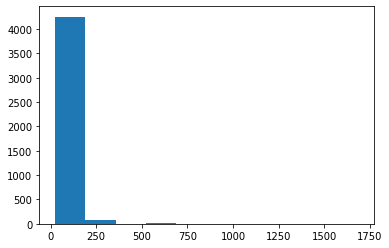

In [54]:
plt.hist(y_pred)

In [51]:
pickle.dump(search, open('wednesday_model_1_random_forest.pkl', 'wb'))

In [42]:
pipeline = make_pipeline(XGBRegressor())

param_grid = {
    'xgbregressor__n_estimators': [500, 1000, 2000],
    'xgbregressor__max_depth': [3, 7, 12, 20]
}

search2 = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1)

search2.fit(X_train, y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  4.6min remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.0min finished
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Serie

[11:04:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [45]:
print('best hyperparams', search2.best_params_)
print('cross-val RMSLE', search2.best_score_)

best hyperparams {'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 500}
cross-val RMSLE -45856.77081840986


In [62]:
y_pred = search2.predict(X_test)
print('rmse', rmse(y_test, y_pred))
# print('rmsle', rmsle(y_test, y_pred))

rmse 198.54068870042022


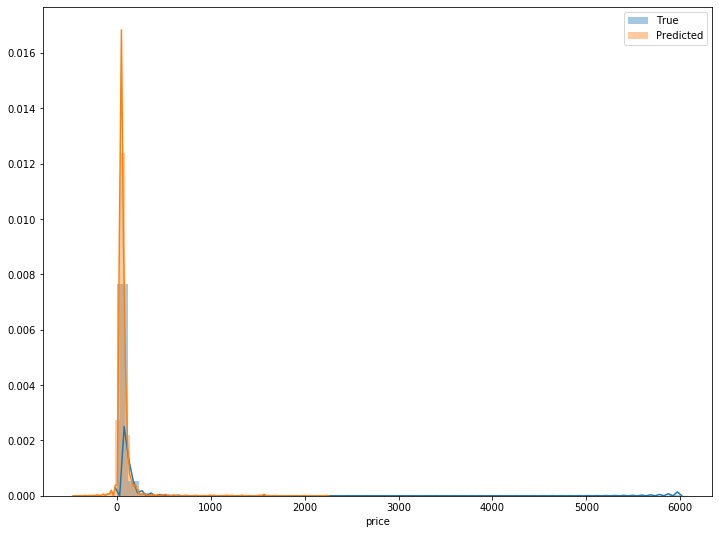

In [56]:
plt.figure(figsize=(12, 9))
sns.distplot(y_test, label='True')
sns.distplot(y_pred, label='Predicted')
plt.legend();

In [68]:
(y_pred < 0).sum()

82

In [118]:
train, test = train_test_split(df_small, test_size=0.20, shuffle=True)

target = 'price'
features = ['neighborhood', 'room_type', 'accommodates', 'bedrooms',
            'number_of_reviews', 'wifi', 'cable_tv', 'washer', 'kitchen']

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [119]:
# normalizing 

mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /=std

In [120]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', 
                          input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [121]:
k = 4
num_val_samples = len(X_train) // k
num_epochs = 20
all_scores = []
# all_mae_histories = []

# K-fold validation
for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i + num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples::]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=1)
#     mae_history = history.history['val_mean_absolute_error']
#     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
#     all_scores.append(val_mae)

processing fold # 0
Epoch 1/20
13107/13107 [==============================] - 12s 890us/step - loss: 55415.5498 - mean_absolute_error: 31.6126
Epoch 2/20
13107/13107 [==============================] - 13s 997us/step - loss: 55161.4242 - mean_absolute_error: 30.9264
Epoch 3/20
13107/13107 [==============================] - 12s 934us/step - loss: 55265.6761 - mean_absolute_error: 30.8758
Epoch 4/20
13107/13107 [==============================] - 13s 1ms/step - loss: 55116.3986 - mean_absolute_error: 30.9468
Epoch 5/20
13107/13107 [==============================] - 12s 889us/step - loss: 55121.6163 - mean_absolute_error: 30.9655
Epoch 6/20
13107/13107 [==============================] - 12s 880us/step - loss: 55134.3589 - mean_absolute_error: 30.8484
Epoch 7/20
13107/13107 [==============================] - 11s 845us/step - loss: 54896.0800 - mean_absolute_error: 30.7912
Epoch 8/20
13107/13107 [==============================] - 11s 811us/step - loss: 54955.0966 - mean_absolute_error: 30.681

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show();

In [122]:
y_pred = model.predict(X_test)

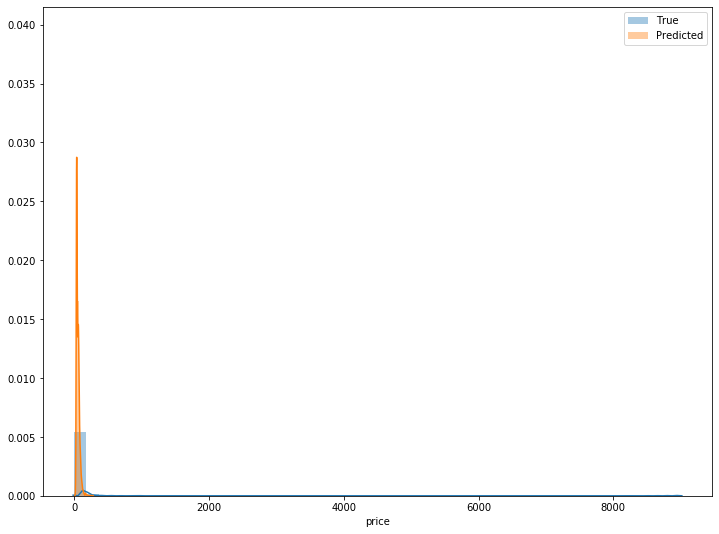

In [123]:
plt.figure(figsize=(12, 9))
sns.distplot(y_test, label='True')
sns.distplot(y_pred, label='Predicted')
plt.legend();

In [125]:
y_pred[100]

array([25.07254], dtype=float32)

In [144]:
(y_pred < 40).sum()

1699

In [126]:
pickle.dump(model, open('wednesday_model_4_keras.pkl', 'wb'))

In [140]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_absolute_error',
                                cv='prefit', n_iter=10)

permuter.fit(X_test, y_test)
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
4.1196 ± 0.1871,room_type
3.5270 ± 0.2427,accommodates
1.0084 ± 0.0961,bedrooms
0.7564 ± 0.1525,cable_tv
0.7086 ± 0.1216,neighborhood
0.3231 ± 0.0738,number_of_reviews
0.1200 ± 0.0566,wifi
0.1182 ± 0.0809,washer
0.0967 ± 0.0827,kitchen


In [100]:

sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']